# Agrupamiento conocido - Basado en particiones: Algoritmo Kmeans ++

### Librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D

### Carga de datos

In [2]:
#Carga de datos
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
# Valores de la clase
Dy = D[:,2]

### Descripción de los datos cargados

El dataset cargado tiene 1999 instancias.
 
Matriz original D:  [[ 51.72   5.     2.  ]
 [ 47.93   5.     2.  ]
 [220.39   7.     3.  ]
 ...
 [ 30.15   6.     2.  ]
 [ 49.9    6.     2.  ]
 [ 40.66   7.     2.  ]]
 
Matriz sin los valores de la clase:  [[ 51.72   5.  ]
 [ 47.93   5.  ]
 [220.39   7.  ]
 ...
 [ 30.15   6.  ]
 [ 49.9    6.  ]
 [ 40.66   7.  ]]
 
Matriz de los valores de la clase:  [2. 2. 3. ... 2. 2. 2.]


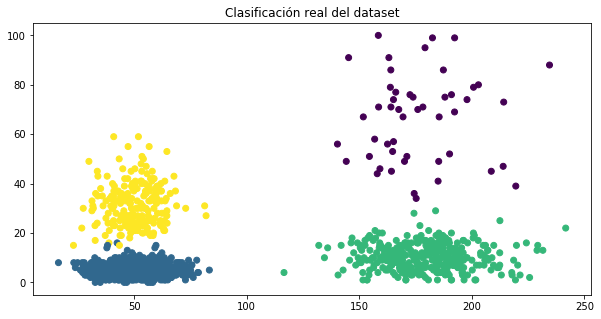

In [3]:
print('El dataset cargado tiene',Dy.size,'instancias.')
print(' ')
print ('Matriz original D: ', D)
print(' ')
print ('Matriz sin los valores de la clase: ', Dx)
print(' ')
print ('Matriz de los valores de la clase: ',  Dy)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)
ax.set_title('Clasificación real del dataset')
fig.text=''


### Funciones

In [4]:
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
   
    return interior/sumTotal

def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], cat_pred==clusts[j])) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales[k] * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2*prec*rec/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign


In [5]:
def agrupamiento_kmeans(matrizDatosAClasificar, K):
    modelo = KMeans(n_clusters = K)
    modelo = modelo.fit(matrizDatosAClasificar)
    Dyp = modelo.predict(matrizDatosAClasificar)
    Centros = modelo.cluster_centers_
    
    return  (Dyp, Centros)

def obtener_valor_k():
    rsilueta = np.zeros(9)
    rrsquare = np.zeros(9)
    for k in np.arange(2,11):
        modelo = KMeans(n_clusters=k)
        modelo = modelo.fit(Dx)
        Dyp_sk = modelo.predict(Dx)
        cDx_sk = modelo.cluster_centers_
        rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
        rrsquare[k-2]  = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)
        #rrsquare[k-2]  = r2_score(Dy, Dyp_sk)

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")

    fig.text=''
    

### Ejecución del algoritmo y resultados

### Elegir el valor de k

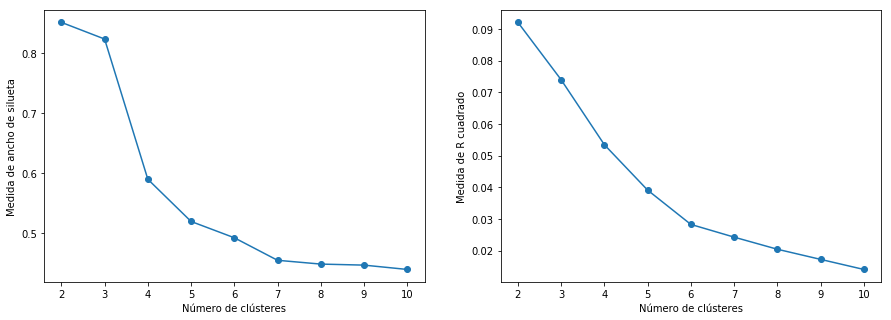

In [6]:
obtener_valor_k()


K= 4 es el valor en el que se provoca un cambio de tendencia (prueba del codo), este valor indica el número de cluster que mejor se ajusta en el K-Means


Centros encontrados por Kmeans++
[[ 50.24671674   5.20600858]
 [179.3065043   10.59025788]
 [175.6826087   68.36956522]
 [ 50.78213592  32.0776699 ]]


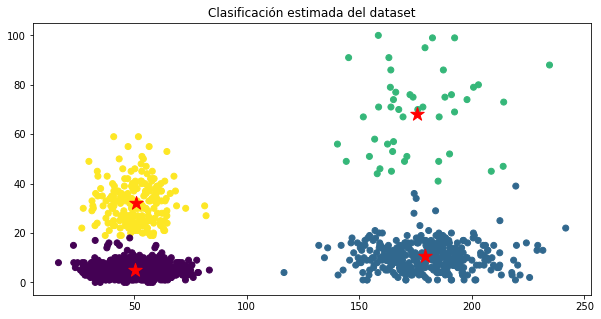

In [7]:
K = 4
Dyp,Centros = agrupamiento_kmeans(Dx, K)


print("Centros encontrados por Kmeans++")
print(Centros)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(Centros[:,0],Centros[:,1], marker='*', s=200, c='r')
ax.set_title('Clasificación estimada del dataset')
fig.text=''

### Comparación de resultados estimados con valores reales

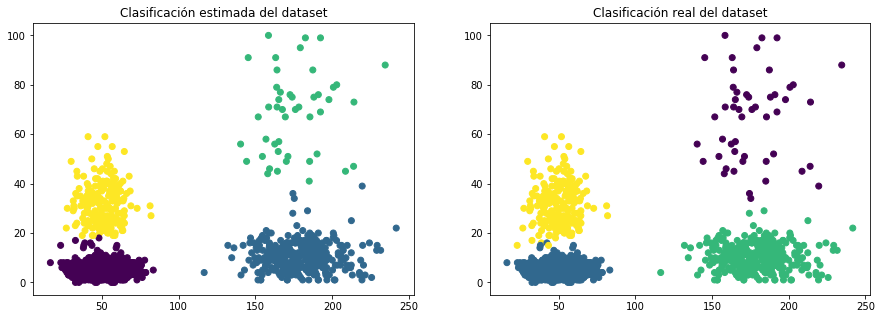

In [8]:
# Visualizamos gráficamente los datos 
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('Clasificación estimada del dataset')
ax1.scatter(Dx[:,0],Dx[:,1], c=Dyp)

ax2.set_title('Clasificación real del dataset')
ax2.scatter(Dx[:,0],Dx[:,1], c=Dy)
fig.text=''

### Métricas extrínsecas

In [11]:
matrizConfusion = matriz_confusion(Dy,Dyp)
print (' ')
print('Matriz de confusión:')
print(matrizConfusion)
print('El valor del error cometido es = ', medida_error(matrizConfusion))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(matrizConfusion))
print('El valor F1 es = ', medida_f1(matrizConfusion))

 
Matriz de confusión:
[[   0    3   46    0]
 [1393    0    0    0]
 [   0  346    0    0]
 [   5    0    0  206]]
El valor del error cometido es =  0.004002001000500299
La pureza del agrupamiento obtenido es =  0.9959979989994997
El valor F1 es =  0.9959647869241534


### Conclusión

El agrupamiento conseguido con K-means++ es muy bueno, si observamos las métrica F1 es casi 1